# Adding H&E information

In case you have an H&E slide aligned with your Spatial Transcriptomics data, you can train a new `Novae` model in multimodal mode.

To handle Spatial Transcriptomics combined with H&E data, `novae` uses [`sopa`](https://gustaveroussy.github.io/sopa/) and [`spatialdata`](https://spatialdata.scverse.org/en/latest/) as a backend.
To use these libraries, install `novae` with the `multimodal` extra, for instance:

```sh
# just the multimodal extra
pip install 'novae[multimodal]'

# with the CONCH extra, if you want CONCH embeddings
pip install 'novae[multimodal,conch]'
```


In [ ]:
import sopa

import novae

## Create a SpatialData object

You can open the data of one sample with one of the readers from [`sopa.io`](https://gustaveroussy.github.io/sopa/api/readers/).

If you don't have your own data, you can also download [this Xenium sample from 10X Genomics](https://www.10xgenomics.com/datasets/xenium-human-lung-cancer-post-xenium-technote) (in the "Output" panel, select "Xenium Prime 5K").


In [9]:
sdata = sopa.io.toy_dataset(as_output=True, genes=500)

[INFO] (sopa.utils.data) Image of size (4, 2048, 2048) with 400 cells and 100 transcripts per cell
[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 400 cells


[                                        ] | 0% Completed | 116.25 us

/Users/quentinblampey/dev/novae/.venv/lib/python3.11/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 363.41 ms


[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 400 cells with mode='average'


[########################################] | 100% Completed | 208.66 ms


/Users/quentinblampey/dev/novae/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [10]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
├── Shapes
│     └── 'cellpose_boundaries': GeoDataFrame shape: (400, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (400, 500)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), transcripts (Points), cellpose_boundaries (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

### 1. Computing patch embeddings

We can define patches and use a computer vision model to extract embeddings from each patch. Here, to make it faster, we only compute patches which touches at least one cell, which may considerably reduce the number of patches.

By default, we use CONCH, which requires the two following step:

1. If not done yet, install the CONCH extra with `pip install 'novae[multimodal,conch]'`
2. Log in Hugging Face and approve their License, see [here](https://huggingface.co/MahmoodLab/CONCH).

⚠️ You can use other models, see the [sopa documentation](https://gustaveroussy.github.io/sopa/api/patches/#sopa.patches.compute_embeddings) for more details.

This can be done via [`compute_histo_embeddings`](../../api/data/#novae.compute_histo_embeddings), as below. Note that we used `device="cuda"` to accelerate the embeddings computation.


In [ ]:
novae.compute_histo_embeddings(sdata, model="conch")  # , device="cuda")

/Users/quentinblampey/.cache/huggingface/modules/transformers_modules/MahmoodLab/TITAN/b2fb4f475256eb67c6e9ccbf2d6c9c3f25f20791/conch_v1_5.py:687: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

### 2. Assigning the embeddings to the cells

Now that we have one embedding per patch, we can compute a PCA of these embeddings add assign to each cell the embedding of the closest patch. This can be done via [`compute_histo_pca`](../../api/data/#novae.compute_histo_pca) as below.

> We will have one patch embedding per cell (multiple cells may share the same embedding). This embedding is an H&E representation of the cell neighborhood, not just the cell itself.


In [ ]:
novae.compute_histo_pca(sdata)

### (Optional) show the CONCH embeddings

The CONCH embeddings are added as an AnnData table to the `SpatialData` object. You can show any dimension of these embeddings spatially as below:


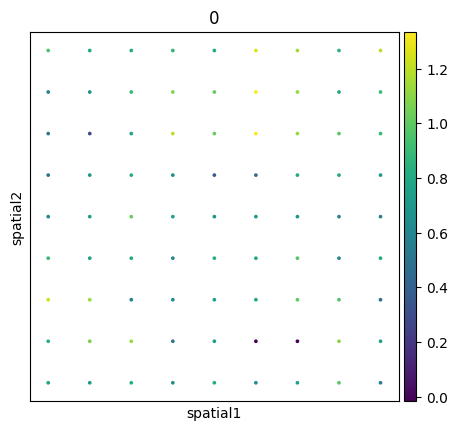

In [26]:
import scanpy as sc

# dimension number 0 of the CONCH embeddings
sc.pl.spatial(sdata["conch_embeddings"], color="0", spot_size=10)

## Training Novae

Now, we can go back to our cell-by-gene `AnnData` object. It's stored inside the `SpatialData` object:


In [31]:
adata = sdata["table"]

We see that we now have `histo_embeddings` in `adata.obsm`:


In [29]:
adata.obsm

AxisArrays with keys: intensities, spatial, histo_embeddings, novae_latent

As is the other tutorials, we compute the [`spatial_neighbors`](../../api/utils/#novae.spatial_neighbors):


In [13]:
novae.spatial_neighbors(adata, radius=80)

[INFO] (novae.utils.build) Computing graph on 400 cells (coord_type=generic, delaunay=True, radius=[0.0, 80.0], n_neighs=None)
[WARNING] (novae.utils.build) The mean number of neighbors is 0.98, which is very low. Consider re-running `novae.spatial_neighbors` with a different `radius` threshold.


And we can check the connectivities, as in the other tutorials:


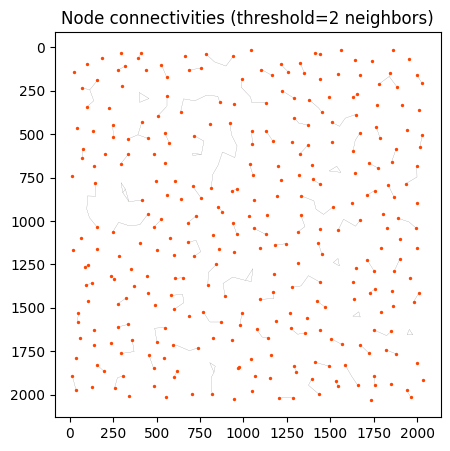

In [30]:
novae.plot.connectivities(adata)

You can then create a new Novae model.

> Note: By default it will initialize the gene embeddings via a PCA. You can also provide a `scgpt_model_dir` (see the docs [here](../../api/Novae/#novae.Novae.__init__)) to replace the PCA.

> Note 2: You can also fine-tune a pretrained model as in the other tutorials. It will automatically detect it has to use the multimodal mode, but this has not been extensively tested.


In [14]:
model = novae.Novae(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO] (novae.module.embed) Running PCA embedding initialization


Normally, showing the model now shows `Multimodal: True`. Note that `Trained: False` indicated the model is still not trained.


In [33]:
model

Novae model
   ├── Known genes: 60697
   ├── Parameters: 32.1M
   ├── Model name: MICS-Lab/novae-human-0
   ├── Trained: True
   └── Multimodal: False

In [40]:
model.fit(adata)  # accelerator="cuda", num_workers=4, lr=2e-4, max_epochs=40)

[WARNING] (novae.data.dataset) Only 33.00% of the cells have a valid neighborhood.
Consider running `novae.spatial_neighbors` with a larger `radius`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/quentinblampey/dev/novae/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | cell_embedder | CellEmbedder      | 31.3 M | train
1 | encoder       | GraphEncoder      | 694 K  | train
2 | augmentation  | GraphAugmentation | 0      | train
3 | swav_head     | SwavHead          | 32.8 K | train
------------------------------------------------------------
989 K     Trainable params
31.1 M    Non-trainable params
32.1 M    Total params
128.266   Total estimated model params size (MB)
82        Modules

In [18]:
model.compute_representations(adata)  # , accelerator="cuda", num_workers=4)

[WARNING] (novae.data.dataset) Only 33.00% of the cells have a valid neighborhood.
Consider running `novae.spatial_neighbors` with a larger `radius`.


Computing representations:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
model.assign_domains(adata, level=8)

'novae_domains_8'

[INFO] (novae.utils._validate) Using obs_key='novae_domains_8' by default.


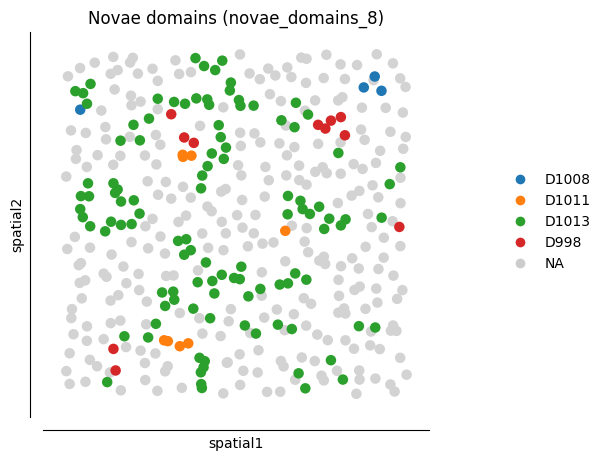

In [20]:
novae.plot.domains(adata)